# Initial Analysis - Proposal

In [11]:
import pandas as pd
import networkx as nx
import numpy as np

import matplotlib as plt
import matplotlib.pyplot as plt

#from matplotlib import pylab


## Analyzing the Graph

### Load required data

In [12]:
articles = pd.read_table("data/graph/articles.tsv", skiprows=11, names=["article"])

categories = pd.read_csv("data/graph/categories.tsv", skiprows=12, sep="\t", names=["article", "category"])

links = pd.read_csv("data/graph/links.tsv", skiprows=11, sep="\t", names=["article1", "article2"])

articles.head(5)

,article
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts


### Create the graph

In [13]:
wiki_graph = pd.DataFrame(columns=["article", "category", "links", "links_count"])

wiki_graph["article"] = articles["article"]

wiki_graph["links"] = [list() for x in range(len(wiki_graph.index))]
wiki_graph["links_count"] = [0 for x in range(len(wiki_graph.index))]

grouped_categories = categories.groupby("article")

for entry in grouped_categories:
    article_name = entry[0]
    cats_df = entry[1]["category"]
    cats_list = cats_df.values.tolist()

    indices = wiki_graph.index[wiki_graph["article"] == article_name].tolist()
    for i in indices:
        wiki_graph.at[i, "category"] = cats_list

grouped_links = links.groupby("article1")

for entry in grouped_links:
    article_name = entry[0]
    links_df = entry[1]["article2"]
    links_list = links_df.values.tolist()

    indices = wiki_graph.index[wiki_graph["article"] == article_name].tolist()
    for i in indices:
        wiki_graph.at[i, "links"] = links_list
        wiki_graph.at[i, "links_count"] = len(links_list)

wiki_graph.sample(5)

,article,category,links,links_count
543,Belfast,[subject.Geography.Geography_of_Great_Britain],"[American_football, Bronze_Age, City_status_in...",19
1008,Computer_programming,[subject.IT.Computer_Programming],"[Algorithm, BASIC, Blaise_Pascal, C%2B%2B, Lin...",10
795,Captain_Marvel_%28DC_Comics%29,[subject.Everyday_life.Cartoons],"[Achilles, Actor, Adolf_Hitler, Ancient_Egypt,...",20
3753,Skiing,[subject.Everyday_life.Sports],"[13th_century, 19th_century, 20th_century, Asi...",23
3803,South_Africa,[subject.Geography.African_Geography.African_C...,"[AIDS, Africa, Afrikaans, Agriculture, Atlanti...",101


#### Checking Null & errors

In [ ]:
print(wiki_graph["article"].is_unique)
print(len(wiki_graph))
print(wiki_graph.shape[0])
print(wiki_graph.shape[1])
print(wiki_graph.index)

True
4604
4604
4
RangeIndex(start=0, stop=4604, step=1)


#### Visualizations

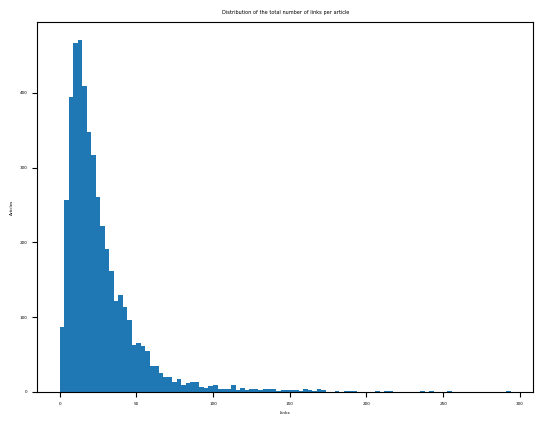

In [14]:
links_counts = wiki_graph["links_count"].values

plt.hist(links_counts, bins=100)
plt.title("Distribution of the total number of links per article")
plt.xlabel("Links")
plt.ylabel("Articles")
plt.show()

                                    article
category                                   
subject.Art.Art                          36
subject.Art.Artists                       2
subject.Business_Studies.Business        28
subject.Business_Studies.Companies       18
subject.Business_Studies.Currency        14


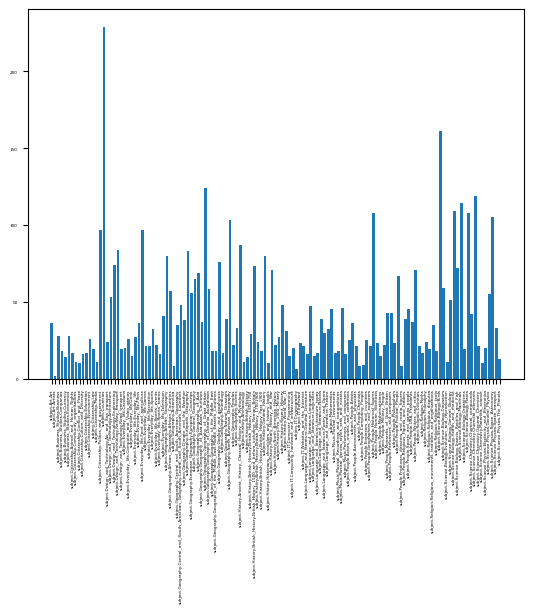

In [16]:
groups = categories.groupby("category").count()

print(groups.head())

labels = list(groups.index)
values = list(groups["article"])
X_axis = np.arange(len(labels))

plt.rcParams["font.size"] = "3"

plt.xticks(rotation=90)
plt.bar(labels, values)
plt.show()

In [17]:
#Highest values of our categories
groups = categories.groupby("category").count()
values = list(groups["article"])
highest_cat = groups.sort_values(ascending=False,by=['article'])
highest_cat.head(20)

,article
category,
subject.Countries,229
subject.Science.Biology.Birds,161
subject.Geography.Geography_of_Great_Britain,124
subject.Science.Chemistry.Chemical_elements,119
subject.Science.Biology.Mammals,114
subject.Science.Biology.Health_and_medicine,109
subject.Science.Biology.Plants,108
subject.People.Historical_figures,108
subject.Science.Physics.Space_Astronomy,105


In [18]:
def sort_dict_by_value(dict):
    return sorted(dict.items(), key=lambda x: x[1], reverse=True)


In [ ]:
wiki_graph[wiki_graph["article"] == "Badugi"]
articles[articles["article"] == "Badugi"]

,article
441,Badugi


Badugi
??
Color_Graphics_Adapter
??
Directdebit
??
Donation
??
Douglas_DC-4
??
Duchenne_muscular_dystrophy
??
Klinefelter%27s_syndrome
??
Local_community
??
Lone_Wolf_%28gamebooks%29
??
Osteomalacia
??
Private_Peaceful
??
Schatzki_ring
??
Suikinkutsu
??
Underground_%28stories%29
??
Vacutainer
??
Wikipedia_Text_of_the_GNU_Free_Documentation_License
??
Wowpurchase
??
4592
106647
4604


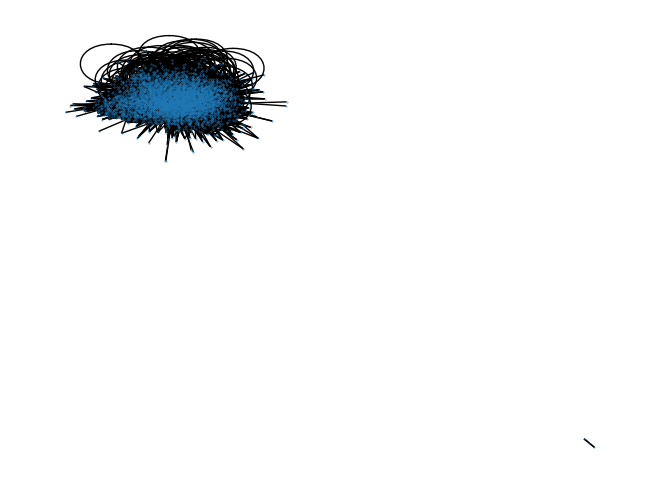

In [22]:
G = nx.Graph()

sampled_wiki_graph = wiki_graph#.sample(100, replace=False)
counter = 0
empty_nodes=[]
for ind in sampled_wiki_graph.index:
    counter +=1
    node_name = wiki_graph["article"][ind]
    node_links = wiki_graph["links"][ind]
    if(len(node_links) == 0):
        empty_nodes.append(node_name)
    else :
        for l in node_links:
            G.add_edge(node_name, l)

print("Total number of nodes: "+str(G.number_of_nodes()))
print("Total number of edges: "+str(G.number_of_edges()))
print(counter)

nx.draw(G, with_labels=False, node_size=0.1)
plt.draw()
plt.savefig("wikispeedia_graph1.pdf")

It looks like there is a completely independent group of nodes, unlinked with the others

In [26]:
#Empty nodes, without any links nodes
print("List of "+str(len(empty_nodes))+" empty nodes (articles without any link): ")
print(str(empty_nodes))

List of 17 empty nodes (articles without any link): 
['Badugi', 'Color_Graphics_Adapter', 'Directdebit', 'Donation', 'Douglas_DC-4', 'Duchenne_muscular_dystrophy', 'Klinefelter%27s_syndrome', 'Local_community', 'Lone_Wolf_%28gamebooks%29', 'Osteomalacia', 'Private_Peaceful', 'Schatzki_ring', 'Suikinkutsu', 'Underground_%28stories%29', 'Vacutainer', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License', 'Wowpurchase']


In [27]:
# Graph analytics
pagerankDict = nx.pagerank(G, alpha=0.9)

topN = 10
top_tuples = sort_dict_by_value(pagerankDict)[:topN]
for (key,value) in top_tuples:
    print(key,"->",value)

United_States -> 0.0073487693403575405
United_Kingdom -> 0.00458076938779606
Europe -> 0.004353391538443455
France -> 0.004157386167202908
England -> 0.0036954152923990924
Germany -> 0.0033470404654848645
World_War_II -> 0.003344467147522731
Scientific_classification -> 0.0028688381329989134
London -> 0.0028377288959734394
English_language -> 0.0027092009622877904


In [34]:
print("Total number of nodes: "+str(G.number_of_nodes()))
print("Number of different connected components (directly linked nodes): "+str(len(list(nx.connected_components(G)))))
print("Number of nodes in the first subgroup: "+str(len(list(nx.connected_components(G))[0])))
print("Number of nodes in the second subgroup: "+str(len(list(nx.connected_components(G))[1])))
print("Components of the second subgroup: "+str(list(nx.connected_components(G))[1]))

Total number of nodes: 4592
Number of different connected components (directly linked nodes): 2
Number of nodes in the first subgroup: 4589
Number of nodes in the second subgroup: 3
Components of the second subgroup: {'Friend_Directdebit', 'Directdebit', 'Sponsorship_Directdebit'}


## Analyze the paths

In [35]:
def quantize_path(str_path):
    return str_path.split(";")

def get_start_node(list_path):
    return list_path[0]

def get_target_node(list_path):
    return list_path[len(list_path)-1]

In [36]:
paths_finished = pd.read_csv(
    "data/graph/paths_finished.tsv",
    skiprows=15,
    sep="\t",
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating", "status","start", "target"],
)

paths_finished["status"] = ["Success" for x in range(len(paths_finished.index))]
#paths_finished["type"] = ["Success" for x in range(len(paths_finished.index))]

paths_finished["path"] = paths_finished["path"].apply(quantize_path)
paths_finished["start"] = paths_finished["path"].apply(get_start_node)
paths_finished["target"] = paths_finished["path"].apply(get_target_node)

paths_finished = paths_finished.drop(columns=["hashedIpAddress", "timestamp"])

paths_finished.tail()

,durationInSec,path,rating,status,start,target
51313,66,"[Yagan, Ancient_Egypt, Civilization]",NaN,Success,Yagan,Civilization
51314,165,"[Yagan, Folklore, Brothers_Grimm, <, 19th_cent...",3.0,Success,Yagan,Fiction
51315,228,"[Yagan, Australia, England, France, United_Sta...",NaN,Success,Yagan,U.S._Open_%28tennis%29
51316,56,"[Yarralumla%2C_Australian_Capital_Territory, A...",1.0,Success,Yarralumla%2C_Australian_Capital_Territory,Abraham_Lincoln
51317,30,"[Ziad_Jarrah, Germany, Jew]",NaN,Success,Ziad_Jarrah,Jew


In [37]:
paths_unfinished = pd.read_csv(
    "data/graph/paths_unfinished.tsv",
    skiprows=19,
    sep="\t",
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
)

paths_unfinished = paths_unfinished.drop(columns=["hashedIpAddress", "timestamp"])

paths_unfinished["status"] = ["Fail" for x in range(len(paths_unfinished.index))]
#paths_unfinished["rating"] = [-999 for x in range(len(paths_unfinished.index))]

paths_unfinished["path"] = paths_unfinished["path"].apply(quantize_path)
paths_unfinished["start"] = paths_unfinished["path"].apply(get_start_node)

#Should we drop timeouts?
paths_unfinished = paths_unfinished[paths_unfinished["type"] != "timeout"]

paths_unfinished.head()

,durationInSec,path,target,type,status,start
1,49,[Paraguay],Mount_St._Helens,restart,Fail,Paraguay
5,175,"[4-2-0, United_States, Agriculture, Sugar, Aus...",Cane_Toad,restart,Fail,4-2-0
6,19,[Logic],Moon_landing,restart,Fail,Logic
9,8,[Niobium],Beeching_Axe,restart,Fail,Niobium
10,334,"[Saint_Kitts_and_Nevis, United_Kingdom, World_...",Sandy_Koufax,restart,Fail,Saint_Kitts_and_Nevis


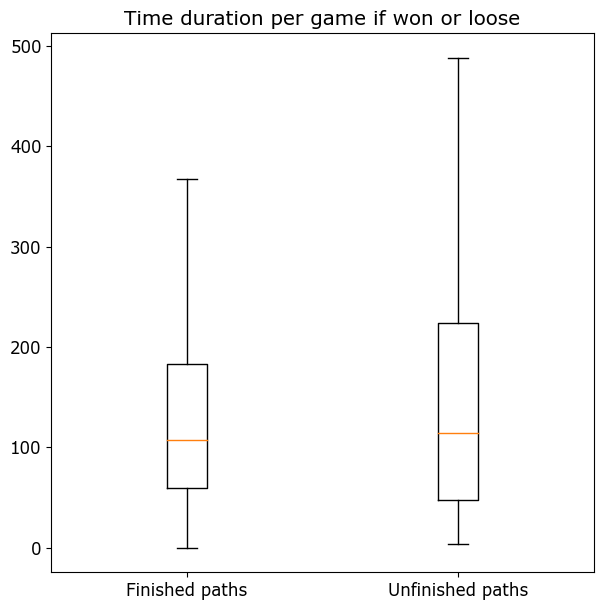

In [54]:
#Time duration analysis
duration_finish=paths_finished["durationInSec"].to_numpy()
duration_unfinish=paths_unfinished["durationInSec"].to_numpy()

duration = [duration_finish,duration_unfinish]

fig = plt.figure(figsize =(7, 7))# Creating plot
plt.rcParams["font.size"] = "12"

plt.boxplot(duration,showfliers=False,labels=["Finished paths","Unfinished paths"])
plt.title("Time duration per game if won or loose")
plt.show()

In [38]:
red_paths_finished = paths_finished.drop(columns=["rating"])
red_paths_unfinished = paths_unfinished.drop(columns=["type"])

paths = pd.concat([red_paths_finished,red_paths_unfinished],axis=0).drop(columns=["durationInSec"])

paths = paths.reindex(columns=["start","target","status","path"])

paths.tail()

,start,target,status,path
24866,Wine,History_of_post-Soviet_Russia,Fail,"[Wine, Georgia_%28country%29, Russia]"
24867,Turks_and_Caicos_Islands,Iraq_War,Fail,"[Turks_and_Caicos_Islands, United_States, Iraq..."
24868,Franz_Kafka,Cholera,Fail,"[Franz_Kafka, Tuberculosis, World_Health_Organ..."
24869,Modern_history,Hollandic,Fail,[Modern_history]
24872,Mark_Antony,Feather,Fail,"[Mark_Antony, Rome, Tennis, Hawk-Eye, Computer]"


In [39]:
paths = pd.DataFrame(columns=["start", "path", "target", "failed", "rating", "type", "hashedIpAddress", "timestamp", "durationInSec"])
paths.head()

,start,path,target,failed,rating,type,hashedIpAddress,timestamp,durationInSec
